In [4]:
import ROOT
import numpy as np
import pandas as pd
ROOT.ROOT.EnableImplicitMT()

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Info in <ACLiC>: unmodified script has already been compiled and loaded
Info in <ACLiC>: unmodified script has already been compiled and loaded


In [32]:
date = "JUL31"

chainSGN = ROOT.TChain("events")
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1038_GFcat_OmegaCat_2018.root".format(date))
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1039_GFcat_Phi3Cat_2018.root".format(date))
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1040_GFcat_D0StarRhoCat_2018.root".format(date))
chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1041_GFcat_D0StarCat_2018.root".format(date))

chainBKG = ROOT.TChain("events")
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc10_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc11_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc12_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc13_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc14_GFcat_Phi3Cat_2018.root".format(date))

dfSGN = ROOT.RDataFrame(chainSGN)
dfSGN = (dfSGN.Define("scale", "w*lumiIntegrated")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)"))


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


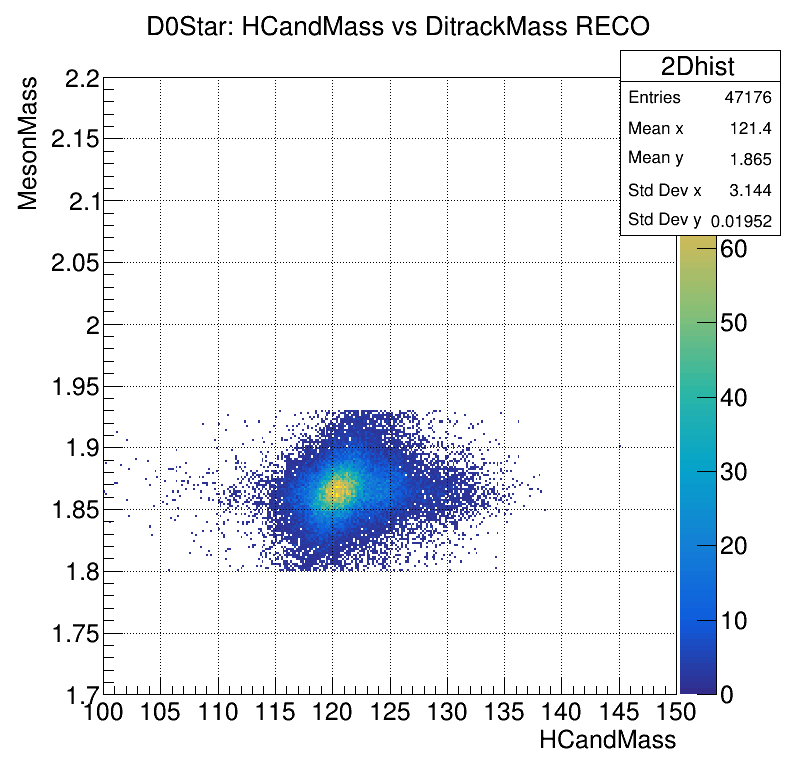

In [39]:
canvas = ROOT.TCanvas("canvas", "canvas", 800, 800)

nbins, xlow, xhigh, ylow, yhigh = 300, 100, 150, 1.7, 2.2
#nbins, xlow, xhigh, ylow, yhigh = 300, 124, 126, 1.97, 2.05

h = dfSGN.Histo2D(("2Dhist", "D0Star: HCandMass vs DitrackMass RECO", nbins, xlow, xhigh, nbins, ylow, yhigh), "HCandMass", "goodMeson_ditrk_mass")

h.GetXaxis().SetTitle("HCandMass")
h.GetYaxis().SetTitle("MesonMass")
h.GetZaxis().SetTitle("Events")
canvas.SetRightMargin(0.15)
canvas.SetLeftMargin(0.13)

h.SetContour(100)
h.Draw("colz")
canvas.SetGrid()

canvas.Draw()